# Feature selection

# Preparation

## Import

In [107]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

import seaborn as sns
import matplotlib.pyplot as plt

## Data Generation

In [108]:
np.random.seed(42)
df = pd.DataFrame(columns= ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8','c9', 'c10',
                'c11','c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20','target'])
size = 25000

df['c1'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c2'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c3'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c4'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c5'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c6'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c7'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c8'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c9'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c10'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c11'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c12'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c13'] = 0.5 * df['c5']
df['c14'] = 6 * df['c10']
df['c15'] = df['c1'] + np.random.uniform(low=-1, high=1, size=(size,))
df['c16'] =  df['c8'] + df['c9'] + np.random.uniform(low=-5, high=5, size=(size,))
df['c17'] = [i if i>0 else -5 for i in df['c2']]
df['c18'] = np.random.uniform(low=-10, high=10, size=(size,))
df['c19'] = df['c1'] + df['c2'] + np.random.uniform(low=-1, high=5, size=(size,))
df['c20'] = 2 * df['c5'] + np.random.uniform(low=-5, high=5, size=(size,))

df['target'] = 0
relevant_features = ['c1', 'c4', 'c5', 'c8', 'c9', 'c10', 'c11', 'c15', 'c16', 'c18', 'c19']
irrelevant_features = ['c2','c3', 'c6','c7', 'c12', 'c13', 'c14', 'c17', 'c20']
print('weights:')
for i in relevant_features:
    random_weight = np.random.random()+ 0.5
    print(i,'-'*5, random_weight)
    df['target'] += df[i] * random_weight

df['target']+= np.random.normal(0,8,size)

weights:
c1 ----- 1.2059714859733344
c4 ----- 0.8751149502212137
c5 ----- 0.5952658097084016
c8 ----- 0.7123334929992821
c9 ----- 0.5257453622656013
c10 ----- 1.1172706022509735
c11 ----- 1.3637191146211978
c15 ----- 1.2336981872986867
c16 ----- 0.8351878162749968
c18 ----- 1.041981098239774
c19 ----- 0.8532515829721657


In [109]:
df.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c12,c13,c14,c15,c16,c17,c18,c19,c20,target
0,-2.509198,-8.152583,6.944732,-9.962313,1.615581,-7.764636,-8.615766,-3.631936,-4.348241,-3.143187,...,2.132077,0.807790,-18.859125,-3.195090,-8.623572,-5.000000,-3.849825,-7.717378,7.120692,-10.326223
1,9.014286,-8.784925,-0.109659,9.199688,0.539433,8.237702,1.713935,5.702274,-0.826468,7.202421,...,-4.383523,0.269716,43.214528,8.205304,9.841631,-5.000000,-2.540787,3.718376,-0.764000,45.942723
2,4.639879,2.083839,-6.090688,0.706332,-2.979261,-7.799772,5.977375,-0.448894,-8.015690,-2.311557,...,7.026135,-1.489631,-13.869341,3.915757,-11.247008,2.083839,-4.944563,7.196619,-10.439425,-27.124097
3,1.973170,9.322326,4.732836,4.008011,-0.135747,-0.850246,5.289462,3.278600,-1.063259,1.918371,...,6.935942,-0.067873,11.510225,1.920148,4.445639,9.322326,3.445384,13.137511,3.925947,35.355197
4,-6.879627,0.054426,-1.626437,8.251943,-2.698067,-0.765424,6.747924,-6.527875,-5.938373,-6.703065,...,0.690118,-1.349034,-40.218393,-6.110559,-12.642568,0.054426,0.432202,-2.394086,-6.033527,-25.014071


In [110]:
X = df.drop("target", 1)
Y = df["target"]

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\753222560.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop("target", 1)


# Fit and Calculate metrics

We will define functions to assess model perfomance with different features

In [111]:
def calculate_metrics(model, X, features,  Y):
    '''Get model evaluation metrics on the test set.'''

    y_predict_r = model.predict(X)
    r_sqr = r2_score(Y, y_predict_r)
    mse = mean_squared_error(Y, y_predict_r)
    relev_f =  str(len(set(features).intersection(relevant_features))) + '/' + str(len(relevant_features))
    irrel_f = str(len(set(features).intersection(irrelevant_features))) + '/' + str(len(irrelevant_features))
    return r_sqr, mse, relev_f, irrel_f

def train_and_get_metrics(X, features, Y):
    '''Train Linear Regression and get evaluation metrics'''
    X = X[features]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model1 = LinearRegression().fit(X_train_scaled ,Y_train)
    model2 = RandomForestRegressor(random_state= 42).fit(X_train_scaled ,Y_train)
    r_sqr1, mse1, relev_f1, irrel_f1 = calculate_metrics(model1, X_test_scaled, features, Y_test)
    r_sqr2, mse2, relev_f2, irrel_f2 = calculate_metrics(model2, X_test_scaled, features, Y_test)
    return [['LinearRegression', r_sqr1, mse1, relev_f1, irrel_f1],
            ['RandomForestRegressor', r_sqr2, mse2, relev_f2, irrel_f2]]

def evaluate_model_on_features(X, features, Y):
    '''Train model and display evaluation metrics.'''

    rez = train_and_get_metrics(X, features, Y)
    display_df = pd.DataFrame(rez,
        columns=['Model', 'R^2', "MSE", 'Relevant', 'Irrelevant'])
    return display_df

In [112]:
all_features_eval_df = evaluate_model_on_features(X, X.columns, Y)
all_features_eval_df['Features'] = 'All'

results = all_features_eval_df
results

,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All


In [113]:
all_features_eval_df = evaluate_model_on_features(X, relevant_features, Y)
all_features_eval_df['Features'] = 'Perfect'

results = results.append(all_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\2984841628.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect


# Numerical Feature Selection

## Correlation

First, let's draw correlation matrix

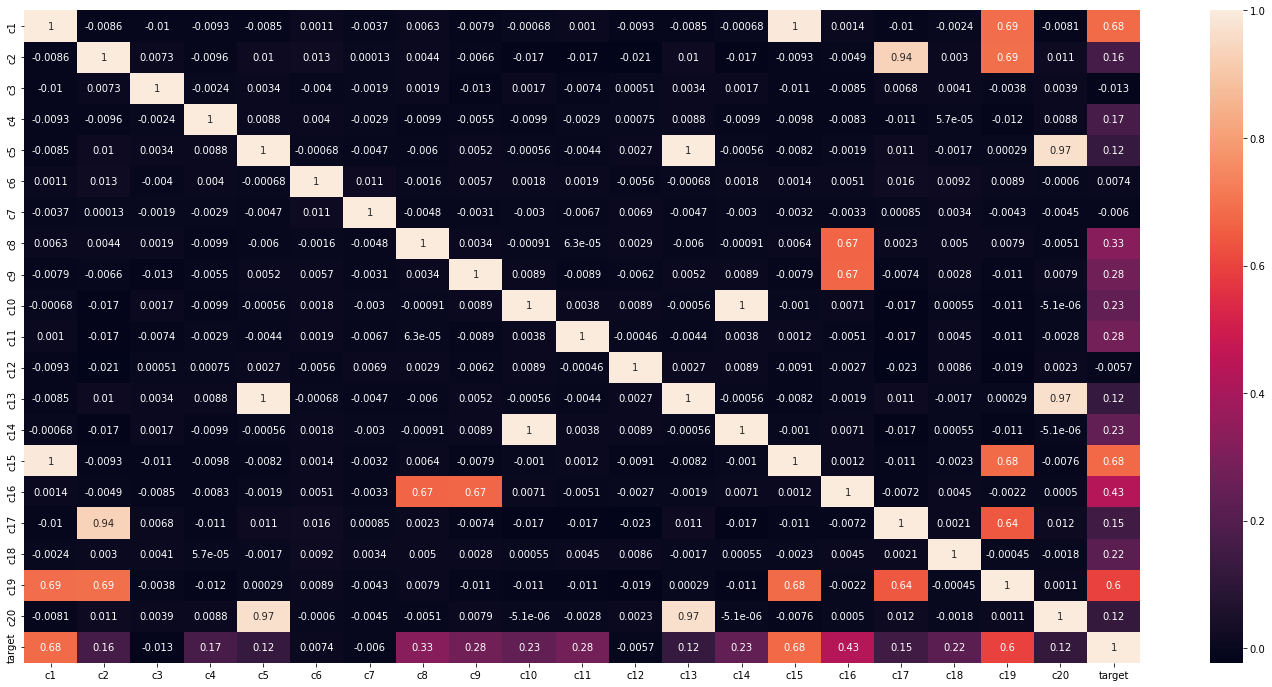

In [114]:
plt.figure(figsize=(25, 12))

# Calculate correlation matrix
cor = df.corr() 

# Plot the correlation matrix
sns.heatmap(df.corr(), annot= True)
plt.show()

First let's delete features with low correlation

In [115]:
cor_target = abs(cor["target"])
high_correlation_features = cor_target[cor_target>0.2]
names = [index for index, value in high_correlation_features.iteritems()]
names.remove('target')
print(names)

['c1', 'c8', 'c9', 'c10', 'c11', 'c14', 'c15', 'c16', 'c18', 'c19']


In [116]:
strong_features_eval_df = evaluate_model_on_features(df, names, Y)
strong_features_eval_df['Features'] = 'Corr'

# Append to results and display
results = results.append(strong_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\3424169843.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(strong_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr


Now we will delete features which are inter-correlated

<AxesSubplot:>

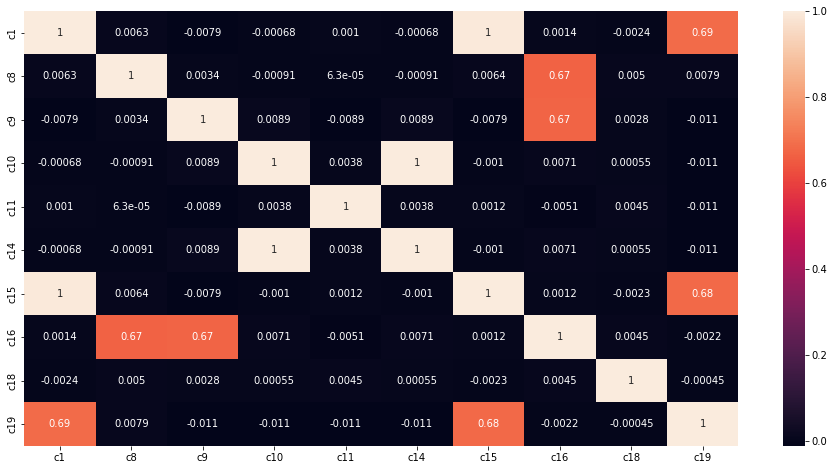

In [117]:
plt.figure(figsize=(16,8))
sns.heatmap(df[names].corr(), annot= True)

As we see `c1` is correlated to `c15`, `c10` to `c14`, so we should reduce each combination to 1

In [118]:
cor= df[names].corr()
intercorrelated_features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if abs(cor.iloc[i, j]) > 0.8:
            colname = cor.columns[i]
            intercorrelated_features.add(colname)

for i in intercorrelated_features:
    names.remove(i)

In [119]:
subset_features_eval_df = evaluate_model_on_features(df, names, Y)
subset_features_eval_df['Features'] = 'No intercorr'

results = results.append(subset_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\2956311646.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr
0,LinearRegression,0.866809,101.592042,8/11,0/9,No intercorr
1,RandomForestRegressor,0.843436,119.420103,8/11,0/9,No intercorr


## Mutual Information

In [120]:
mi = mutual_info_regression(X, Y)
print(mi.reshape(20,1))
mi_score_selected_index = np.where(mi >0.02)[0]
df.columns[mi_score_selected_index]

[[0.30576473]
 [0.01351993]
 [0.        ]
 [0.01001783]
 [0.01499306]
 [0.        ]
 [0.00086445]
 [0.05827194]
 [0.03679469]
 [0.02518002]
 [0.03828459]
 [0.        ]
 [0.01499306]
 [0.02518018]
 [0.30871086]
 [0.11013711]
 [0.01482797]
 [0.03226935]
 [0.22037183]
 [0.00504006]]


Index(['c1', 'c8', 'c9', 'c10', 'c11', 'c14', 'c15', 'c16', 'c18', 'c19'], dtype='object')

In [121]:
subset_features_eval_df = evaluate_model_on_features(df, df.columns[mi_score_selected_index], Y)
subset_features_eval_df['Features'] = 'MI'

# Append to results and display
results = results.append(subset_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\2733508665.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr
0,LinearRegression,0.866809,101.592042,8/11,0/9,No intercorr
1,RandomForestRegressor,0.843436,119.420103,8/11,0/9,No intercorr
0,LinearRegression,0.867414,101.130400,9/11,1/9,MI
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,MI


# Wrapper Methods

Wrapper methods use a model to measure the effectiveness of a particular subset of features. As mentioned in class, one approach is to remove or add features sequentially. You can either start with 1 feature and gradually add until no improvement is made (forward selection), or do the reverse (backward selection). That can be done with the [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) class which uses k-fold cross validation scores to decide which features to add or remove. [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is similar to backwards elimination but uses feature importance scores to prune the number of features. You can also specify how many features to remove at each iteration of the recursion. Let's use this as the wrapper for our model below.

In [122]:
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.pipeline import Pipeline

In [123]:
def run_sfs():
    # Define the model
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, n_features_to_select= 11)
    sfs = sfs.fit(X, Y)
    feature_names = df.drop('target', 1 ).columns[sfs.get_support()]
    
    return feature_names

sfs_feature_names = run_sfs()
sfs_feature_names

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\1663428332.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop('target', 1 ).columns[sfs.get_support()]


Index(['c1', 'c4', 'c5', 'c8', 'c9', 'c10', 'c11', 'c15', 'c16', 'c18', 'c19'], dtype='object')

In [124]:
subset_features_eval_df = evaluate_model_on_features(df, sfs_feature_names, Y)
subset_features_eval_df['Features'] = 'Sequential Sel.'

# Append to results and display
results = results.append(subset_features_eval_df)
results.head(12)

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\3660819338.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr
0,LinearRegression,0.866809,101.592042,8/11,0/9,No intercorr
1,RandomForestRegressor,0.843436,119.420103,8/11,0/9,No intercorr
0,LinearRegression,0.867414,101.130400,9/11,1/9,MI
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,MI


In [125]:
def run_rfe():
    # Define the model
    model = LinearRegression()
    
    # Wrap RFE around the model
    rfe = RFE(model, n_features_to_select= 11)
    
    # Fit RFE
    rfe = rfe.fit(X, Y)
    feature_names = df.drop('target', 1 ).columns[rfe.get_support()]
    
    return feature_names

rfe_feature_names = run_rfe()
rfe_feature_names

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\1378032953.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop('target', 1 ).columns[rfe.get_support()]


Index(['c1', 'c4', 'c5', 'c8', 'c11', 'c13', 'c14', 'c15', 'c16', 'c18',
       'c19'],
      dtype='object')

In [126]:
subset_features_eval_df = evaluate_model_on_features(df, rfe_feature_names , Y)
subset_features_eval_df['Features'] = 'Recursive Elim.'

# Append to results and display
results = results.append(subset_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\1292746553.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr
0,LinearRegression,0.866809,101.592042,8/11,0/9,No intercorr
1,RandomForestRegressor,0.843436,119.420103,8/11,0/9,No intercorr
0,LinearRegression,0.867414,101.130400,9/11,1/9,MI
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,MI


# Embedded methods

## Feature importance

In [127]:
model = LinearRegression().fit(X, Y)
# get importance
importance = pd.Series(model.coef_, index = X.columns)
fi_features= importance[abs(importance)>0.02].index

In [128]:
subset_features_eval_df = evaluate_model_on_features(df, fi_features, Y)
subset_features_eval_df['Features'] = 'Feature Imp.'

# Append to results and display
results = results.append(subset_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\2262111479.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr
0,LinearRegression,0.866809,101.592042,8/11,0/9,No intercorr
1,RandomForestRegressor,0.843436,119.420103,8/11,0/9,No intercorr
0,LinearRegression,0.867414,101.130400,9/11,1/9,MI
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,MI


## L1/Lasso regularization

In [129]:
from sklearn.linear_model import Lasso

In [130]:
lasso = Lasso(alpha=.3)
lasso.fit(X, Y)

Lasso(alpha=0.3)

In [131]:
lasso_coefs = pd.Series(lasso.coef_, index = X.columns)
lasso_features= lasso_coefs[abs(lasso_coefs)>0].index

In [132]:
subset_features_eval_df = evaluate_model_on_features(df, lasso_features, Y)
subset_features_eval_df['Features'] = 'L1/Lasso'

# Append to results and display
results = results.append(subset_features_eval_df)
results

C:\Users\citru\AppData\Local\Temp\ipykernel_10568\2040058680.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_features_eval_df)


,Model,R^2,MSE,Relevant,Irrelevant,Features
0,LinearRegression,0.917128,63.210974,11/11,9/9,All
1,RandomForestRegressor,0.873186,96.728171,11/11,9/9,All
0,LinearRegression,0.917179,63.171863,11/11,0/9,Perfect
1,RandomForestRegressor,0.878886,92.380087,11/11,0/9,Perfect
0,LinearRegression,0.867414,101.130400,9/11,1/9,Corr
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,Corr
0,LinearRegression,0.866809,101.592042,8/11,0/9,No intercorr
1,RandomForestRegressor,0.843436,119.420103,8/11,0/9,No intercorr
0,LinearRegression,0.867414,101.130400,9/11,1/9,MI
1,RandomForestRegressor,0.844684,118.467929,9/11,1/9,MI


# Plotting

As we can see, `Strong features, Subset features and Mutual Information` performed significantly worse in both cases, so we won't plot them

In [137]:
res_to_plot = results.copy()
res_to_plot['Relevant'] = (res_to_plot['Relevant'].str.split('/', expand= True)[0].astype(int)) / 11
res_to_plot['Irrelevant'] = (res_to_plot['Irrelevant'].str.split('/', expand= True)[0].astype(int)) / 11

In [138]:
LR_res = res_to_plot.query('Model == "RandomForestRegressor"')[['Features', 'R^2', 'MSE']]
RF_res = res_to_plot.query('Model == "LinearRegression"')[['Features', 'R^2', 'MSE']]

In [139]:
LR_res.head(3)

,Features,R^2,MSE
1,All,0.873186,96.728171
1,Perfect,0.878886,92.380087
1,Corr,0.844684,118.467929


In [140]:
RF_res.head(3)

,Features,R^2,MSE
0,All,0.917128,63.210974
0,Perfect,0.917179,63.171863
0,Corr,0.867414,101.130400


In [141]:
# data = [[30, 25, 50, 20],
# [40, 23, 51, 17],
# [35, 22, 45, 19]]
# X = np.arange(4)
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
# ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
# ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

<BarContainer object of 9 artists>

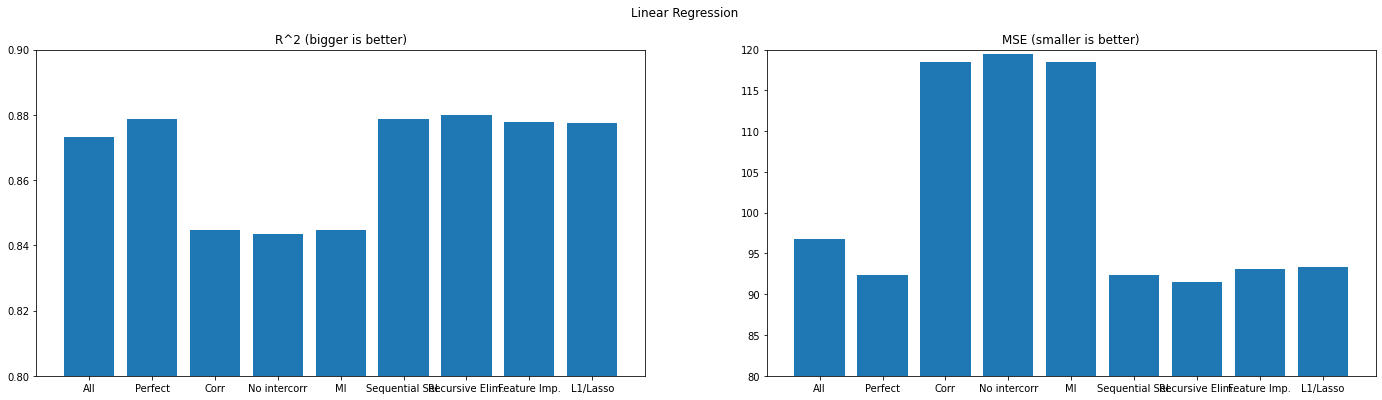

In [148]:
fig, axs = plt.subplots(1,2, figsize=(24, 6))
fig.suptitle('Linear Regression')
axs[0].set_title('R^2 (bigger is better)')
axs[0].set_ylim(0.8, 0.9)
axs[0].bar(x = LR_res['Features'], height = LR_res['R^2'])
axs[1].set_title('MSE (smaller is better)')
axs[1].set_ylim(80, 120)
axs[1].bar(x = LR_res['Features'], height = LR_res['MSE'])

<BarContainer object of 9 artists>

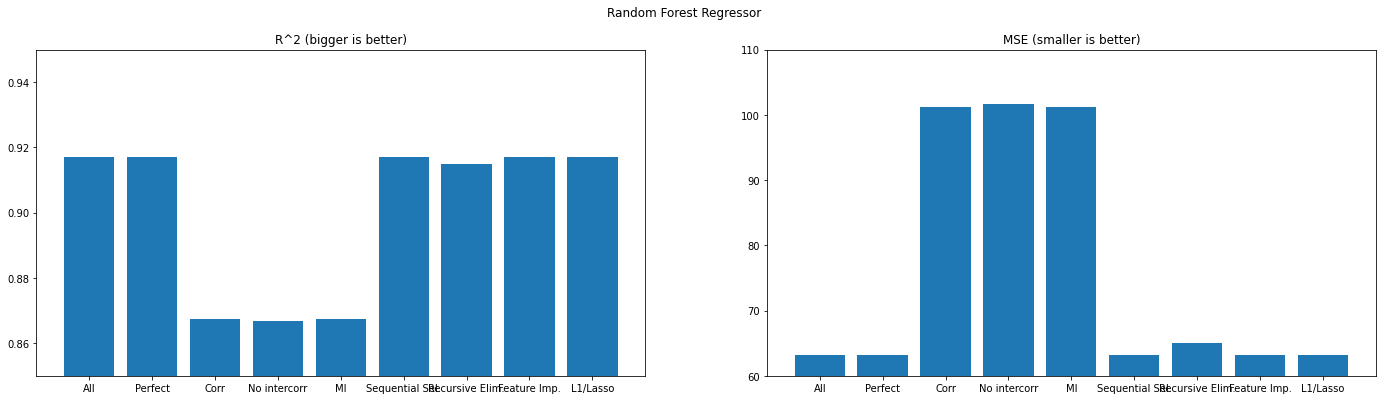

In [152]:
fig, axs = plt.subplots(1,2, figsize=(24, 6))
fig.suptitle('Random Forest Regressor')
axs[0].set_title('R^2 (bigger is better)')
axs[0].set_ylim(0.85, 0.95)
axs[0].bar(x = RF_res['Features'], height = RF_res['R^2'])
axs[1].set_title('MSE (smaller is better)')
axs[1].set_ylim(60, 110)
axs[1].bar(x = RF_res['Features'], height = RF_res['MSE'])

## Conclusion

Feature selection based on correlation and Mutual Infrormation significantly underperformed comparing to ether models.

As we can see, Recursive Feature Elimination performed slightly worse (surprisingly) by means of any metric, while other methods show consistent results. As for relevant features, RFE missed 2 relevant reatures, While Feature Importance and L1 regularisation missed 3 each. So, Sequential Feature selection performed the best, as it managed divide fetures correctly.

In case of Random Forest Regressor, RFE shows slightly better results than perfect model by metrics, despite it missed 2 relevant features and picked 2 irrelevant. I believe it happened because we have too low amount of data. Once again, Sequential Feature selection managed to pick all the features correctly. All the results seem pretty close on this dataset.